<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Functions" data-toc-modified-id="Functions-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Functions</a></span></li><li><span><a href="#Antibodies" data-toc-modified-id="Antibodies-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Antibodies</a></span></li><li><span><a href="#Significant-genes-per-vaccinee---enrichment" data-toc-modified-id="Significant-genes-per-vaccinee---enrichment-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Significant genes per vaccinee - enrichment</a></span></li><li><span><a href="#Significant-genes-between-timepoints-(per-group)" data-toc-modified-id="Significant-genes-between-timepoints-(per-group)-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Significant genes between timepoints (per group)</a></span></li><li><span><a href="#Significant-genes-per-group---DESeq2-(same-timepoint)" data-toc-modified-id="Significant-genes-per-group---DESeq2-(same-timepoint)-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Significant genes per group - DESeq2 (same timepoint)</a></span></li><li><span><a href="#Significant-genes-between-timepoints-(no-groups)" data-toc-modified-id="Significant-genes-between-timepoints-(no-groups)-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Significant genes between timepoints (no groups)</a></span></li><li><span><a href="#Unsupervised-approach" data-toc-modified-id="Unsupervised-approach-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Unsupervised approach</a></span></li><li><span><a href="#Cell-types" data-toc-modified-id="Cell-types-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Cell types</a></span></li></ul></div>

In [1]:
import glob
import itertools
import math
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from joblib import Parallel, delayed
from matplotlib_venn import venn2, venn2_circles
from matplotlib_venn import venn3, venn3_circles
from mpl_toolkits.mplot3d import Axes3D
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import pdist, squareform

import GeneExpressionAnalysis as GEA
import hypergeom

# Functions

In [2]:
def process_ab_file(filepath):

    df = pd.read_excel(filepath, header=[0, 1], sheet_name=1)
    df = df.applymap(lambda x: float(str(x).replace('>', '').replace('<', '').replace(',','.')))
#    df.columns = [' '.join(col).strip() for col in df.columns.values]
    df = df.unstack().reset_index()
    df.columns = ['vaccine', 'day', 'vaccinee', 'value']
    df['day'] = df['day'].apply(lambda x: int(x.replace('Day ', '')))
    
    return df
    
    
def deseq2_analysis(analysis_dir):

    try:
        os.mkdir(analysis_dir)
    except FileExistsError:
        pass
    
    # '../data/Analysis/{}_analysis'.format(sample)
    sample = analysis_dir.split('/')[-1].replace('_analysis', '')
    print(sample)
    lp = GEA.LabelProcessor(readcount_df, data_origin='MMR')
    lp.add_samples('sample', sample)
    lp.generate_DESeq_data('{}/read_counts.txt'.format(analysis_dir),
                           '{}/col_data.txt'.format(analysis_dir))

    run = GEA.DESeq2run('{}/read_counts.txt'.format(analysis_dir),
                    '{}/col_data.txt'.format(analysis_dir),
                    sample_column='sample')
    result_path = run.calc_DEGs(design = 'day', # TO CHECK if replicate needed
                                   to_test={'day': [day_A, day_B]},
                                   R_script_dir=analysis_dir)   

    return result_path[0]

# Antibodies

In [3]:
antibody_df = process_ab_file(os.path.join('..','..','Priorix study - Vaccine serology.xlsx'))
antibody_df['vaccinee'] = antibody_df['vaccinee'].apply(lambda x: x[0]+x[1:].lstrip('0'))
#antibody_df = antibody_df[antibody_df['vaccinee']!='M7'].reset_index(drop=True)
antibody_df['vaccine'] = antibody_df['vaccine'].apply(lambda x: x.replace('/', '-').replace(' ', '_'))
antibody_df.head()

,vaccine,day,vaccinee,value
0,Anti-Measles_IgG_(AU-ml),0,M1,5.0
1,Anti-Measles_IgG_(AU-ml),0,M2,48.1
2,Anti-Measles_IgG_(AU-ml),0,M3,25.4
3,Anti-Measles_IgG_(AU-ml),0,M4,58.9
4,Anti-Measles_IgG_(AU-ml),0,M5,32.0


In [4]:
# make groups by hand based on clustering

measles_groups = {
    'high_AB': [41, 39, 38, 33, 18, 12, 15, 9, 40, 8, 13, 35],
    'low_AB': [26, 21, 25, 20, 22, 29, 3],
    'peak_response': [28, 1, 16, 19],
    'long_response': [23, 14, 4] + [11, 36, 37, 2, 5, 30, 32, 6, 17, 27, 7, 31, 24, 34]
}
inverted_measles_groups = {'M'+str(val) : key for key, value in measles_groups.items() for val in value}

mumps_groups = {
    'low_AB': [29, 1, 20, 23, 32, 11, 40],
    'high_AB': [41, 4, 3, 27, 25, 18, 22, 31, 6, 9, 21, 24],
    'other': [8, 37, 38, 35, 7, 39, 12, 17, 15, 26, 16, 30, 13, 33, 5, 19, 36] + [2, 14, 28, 34]
}
inverted_mumps_groups = {'M'+str(val) : key for key, value in mumps_groups.items() for val in value}

rubella_groups = {
    'low_AB': [22, 32, 15, 33, 24, 8, 28, 14, 35, 40, 2, 1, 11, 36, 38, 4, 6, 5, 20, 23, 30, 12, 37],
    'peak_response': [17, 19, 9, 21, 25, 7, 26, 34, 39, 27, 31, 18, 16, 3],
    'high_AB': [29, 13, 41]
}
inverted_rubella_groups = {'M'+str(val) : key for key, value in rubella_groups.items() for val in value}

groups = {'Anti-Measles_IgG_(AU-ml)': measles_groups, 
          'Anti-Mumps_IgG_(AU-ml)': mumps_groups, 
          'Anti-Rubella_IgG_(IU-ml)': rubella_groups}

inverted_groups = {'Anti-Measles_IgG_(AU-ml)': inverted_measles_groups, 
                   'Anti-Mumps_IgG_(AU-ml)': inverted_mumps_groups, 
                   'Anti-Rubella_IgG_(IU-ml)': inverted_rubella_groups}

Anti-Measles_IgG_(AU-ml)


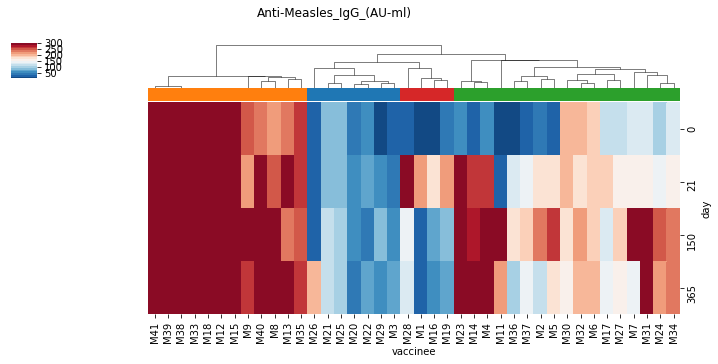

Anti-Mumps_IgG_(AU-ml)


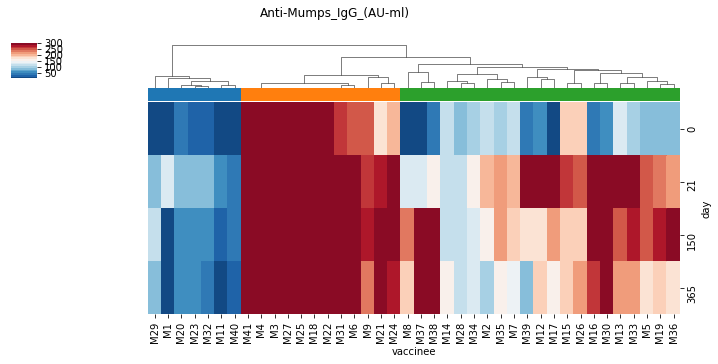

Anti-Rubella_IgG_(IU-ml)


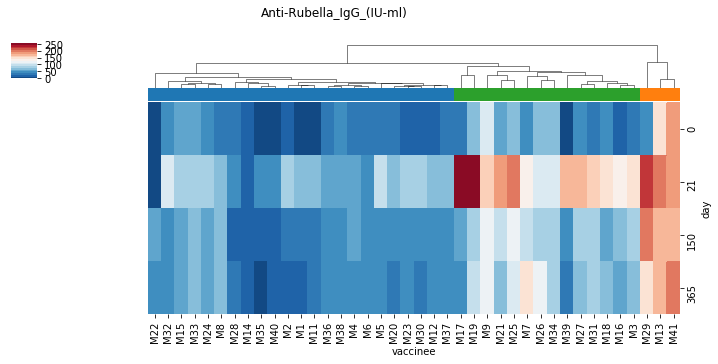

In [5]:
for vaccine in antibody_df['vaccine'].unique():
    
    print(vaccine)
    
    cluster_df = antibody_df[antibody_df['vaccine']==vaccine].pivot_table(
        index='day', columns='vaccinee').fillna(150) # set value of M7 at 150
    cluster_df.columns = cluster_df.columns.get_level_values(1)

    cluster_array = np.asarray(cluster_df)
    col_linkage = linkage(pdist(cluster_array.T), method='average')

    colors = sns.color_palette(n_colors=len(set(inverted_groups[vaccine].values())))
    color_map  = dict(zip(set(inverted_groups[vaccine].values()), colors))
    
    col_colors = [color_map[inverted_groups[vaccine][x]] for x in cluster_df.columns]
    
    g = sns.clustermap(cluster_df,
        col_linkage=col_linkage,
        row_cluster=False,
        cmap=sns.color_palette("RdBu_r", 20),
        figsize=(12, 5),
        col_colors=col_colors).fig.suptitle(f'{vaccine}') 

    plt.savefig('../figures/AB_clustermap_{}'.format(vaccine.replace('/', ':')), dpi=300)
    plt.show()

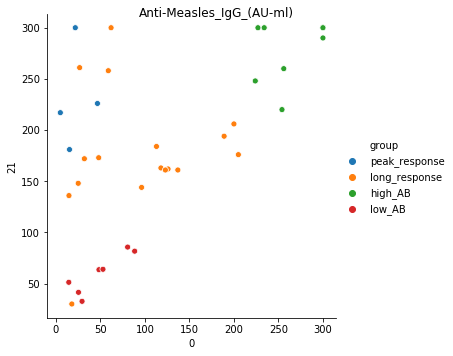

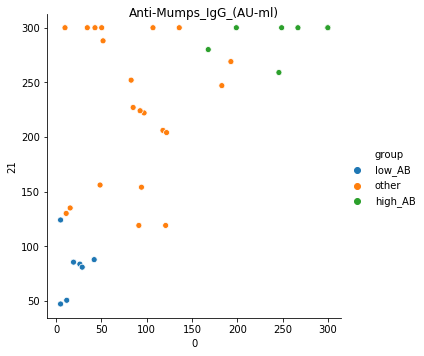

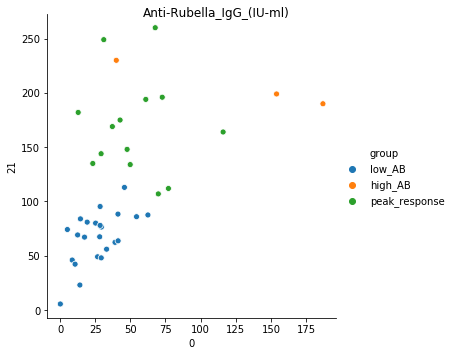

In [6]:
vaccines = antibody_df['vaccine'].unique()

for vaccine in vaccines:
    
    vaccines_df = antibody_df[antibody_df['vaccine']==vaccine]
    vaccines_df = vaccines_df.pivot(index='vaccinee', columns='day', values='value')

    vaccines_df['group'] = pd.DataFrame(vaccines_df.index).applymap(lambda x: inverted_groups[vaccine][x]).set_index(vaccines_df.index)
    
    g = sns.relplot(data=vaccines_df, x=0, y=21, hue='group', 
                    palette=sns.color_palette(n_colors=len(vaccines_df['group'].unique())))
    g.fig.suptitle(vaccine)
    plt.savefig('../figures/AB_scatter_{}.png'.format(vaccine.replace('/', ':')), dpi=300)
    plt.show()

In [7]:
antibody_df = antibody_df.pivot_table(index=['vaccine', 'vaccinee'], columns='day', values='value').reset_index()

In [8]:
for vaccine in vaccines:

    antibody_df.loc[antibody_df['vaccine']==vaccine, 'group'] = antibody_df['vaccinee'].apply(lambda x:
                                                                                              inverted_groups[vaccine][x])
    
display(antibody_df)

day,vaccine,vaccinee,0,21,150,365,group
0,Anti-Measles_IgG_(AU-ml),M1,5.00,217.00,30.8,31.5,peak_response
1,Anti-Measles_IgG_(AU-ml),M11,17.90,30.10,300.0,214.0,long_response
2,Anti-Measles_IgG_(AU-ml),M12,300.00,300.00,300.0,300.0,high_AB
3,Anti-Measles_IgG_(AU-ml),M13,227.00,300.00,236.0,300.0,high_AB
4,Anti-Measles_IgG_(AU-ml),M14,26.70,261.00,276.0,300.0,long_response
5,Anti-Measles_IgG_(AU-ml),M15,300.00,300.00,300.0,300.0,high_AB
6,Anti-Measles_IgG_(AU-ml),M16,15.30,181.00,72.1,56.9,peak_response
7,Anti-Measles_IgG_(AU-ml),M17,113.00,184.00,132.0,145.0,long_response
8,Anti-Measles_IgG_(AU-ml),M18,300.00,300.00,300.0,300.0,high_AB
9,Anti-Measles_IgG_(AU-ml),M19,46.70,226.00,81.0,73.9,peak_response


In [9]:
#ab_days = [0, 21, 150, 365]
#for i in range(len(ab_days)-1):
#    dayA = ab_days[i]
#    dayB = ab_days[i+1]
#    
#    antibody_df['diff: {}-{}'.format(dayB, dayA)] = antibody_df[dayB]-antibody_df[dayA]

In [10]:
#fig = plt.figure()
#ax = fig.add_subplot(111, projection='3d')
#ax.scatter(antibody_df[antibody_df['vaccine']=='Anti-Measles IgG (AU/ml)']['diff: 21-0'], 
#           antibody_df[antibody_df['vaccine']=='Anti-Mumps IgG (AU/ml)']['diff: 21-0'], 
#           antibody_df[antibody_df['vaccine']=='Anti-Rubella IgG (IU/ml)']['diff: 21-0'])
#ax.set_xlabel('X diff_mumps')
#ax.set_ylabel('Y diff_rubella')
#ax.set_zlabel('Z diff_measles')
#plt.show()

In [11]:
#change = 100 # 50
#threshold = 200 # 100
#
#def assign_group(value):
#    day_0 = value[0]
#    day_21 = value[21]
#    
#    if day_21 - day_0 > change:
#        return 'responder'
#    elif day_0 < threshold:
#        return 'no response - low ab'
#    elif day_0 >= threshold:
#        return 'no response - high ab'
#
#    
#for vaccine in vaccines:
#    vaccine_df = antibody_df[antibody_df['vaccine']==vaccine]
#    antibody_df.loc[vaccine_df.index, 'response'] = vaccine_df['diff: 21-0'] > change
#    antibody_df.loc[vaccine_df.index, 'protected'] = vaccine_df[21] > threshold
#    antibody_df.loc[vaccine_df.index, 'quadrant'] = vaccine_df[[0, 21]].apply(assign_group, axis=1)
#    
#antibody_df.to_csv('../data/antibody_df.txt', sep='\t')
#antibody_df.index = antibody_df['vaccinee']
#antibody_df.head()

# Significant genes per vaccinee - enrichment

In [12]:
R_script_dir = '../code/generated_R_scripts'

readcount_df = GEA.collect_data('../original_data', file_pattern = '.*readcounts.txt')

to_drop = [col for col in readcount_df.columns if 'Undetermined' in col]
readcount_df = readcount_df.drop(columns=to_drop)

preproc = GEA.Preprocessor()
readcount_df = preproc.clean(readcount_df, data_origin='MMR')
readcount_df = preproc.combine_lane_counts(readcount_df)

readcount_df.to_csv('../data/readcount_combined.txt', sep='\t', index=False)
readcount_df[[col for col in readcount_df.columns if 'gene' in col]].T.to_csv('../data/readcount_combined_counts.txt', sep='\t')
readcount_df[[col for col in readcount_df.columns if 'gene' not in col]].to_csv('../data/readcount_combined_meta.txt', sep='\t', index=False)

genes = pd.read_csv('../original_data/genes.txt', sep='\t', header=None)
gene_dict = {x: genes.loc[i, 3] for i, x in enumerate(genes[0])}
#readcount_df = readcount_df.rename(columns=gene_dict)

readcount_df.head()

Searching files in ../original_data...
Searching files in ../original_data/read_counts...
File found: 170906_NB501809_0168_AH7NMHBGX3_readcounts.txt
File found: 171013_NB501809_0191_AHN7GCBGX3_readcounts.txt
File found: 171121_NB501809_0211_AHW3JCBGX3_readcounts.txt
File found: 170802_NB501809_0150_AH7NMJBGX3_readcounts.txt
File found: 171027_NB501809_0200_AHMLG2BGX3_readcounts.txt
File found: 170915_NB501809_0174_AHKCMHBGX3_readcounts.txt
File found: 170929_NB501809_0183_AHK5NLBGX3_readcounts.txt
Files found:
../original_data/read_counts/170906_NB501809_0168_AH7NMHBGX3_readcounts.txt
../original_data/read_counts/171013_NB501809_0191_AHN7GCBGX3_readcounts.txt
../original_data/read_counts/171121_NB501809_0211_AHW3JCBGX3_readcounts.txt
../original_data/read_counts/170802_NB501809_0150_AH7NMJBGX3_readcounts.txt
../original_data/read_counts/171027_NB501809_0200_AHMLG2BGX3_readcounts.txt
../original_data/read_counts/170915_NB501809_0174_AHKCMHBGX3_readcounts.txt
../original_data/read_counts

,gene27686,gene37698,gene37699,gene46570,gene46575,gene28963,gene26406,gene21713,gene16201,gene6756,...,gene10081,gene15800,gene6977,gene17256,gene1559,run,name,replicates,sample,day
name,,,,,,,,,,,,,,,,,,,,,
M11_EXP0_1_S28,1070064.0,615748.0,156563.0,70605.0,76505.0,12145.0,8333.0,11419.0,19828.0,5359.0,...,0.0,0.0,0.0,0.0,0.0,170802_NB501809_0150_AH7NMJBGX3,M11_EXP0_1_S28,1,M11,0
M11_EXP0_2_S4,1793590.0,695796.0,231752.0,67744.0,57953.0,13144.0,17416.0,19287.0,20380.0,15599.0,...,0.0,0.0,0.0,0.0,0.0,171013_NB501809_0191_AHN7GCBGX3,M11_EXP0_2_S4,2,M11,0
M11_EXP3_1_S29,1424441.0,672075.0,316520.0,56197.0,44469.0,26590.0,9330.0,14056.0,8945.0,10140.0,...,0.0,0.0,0.0,0.0,0.0,170802_NB501809_0150_AH7NMJBGX3,M11_EXP3_1_S29,1,M11,3
M11_EXP3_2_S5,1828251.0,1212191.0,335492.0,140848.0,131412.0,11728.0,14102.0,18902.0,18389.0,16700.0,...,0.0,0.0,0.0,0.0,0.0,171013_NB501809_0191_AHN7GCBGX3,M11_EXP3_2_S5,2,M11,3
M11_EXP7_1_S30,826915.0,756994.0,221669.0,154362.0,137770.0,10450.0,7863.0,9424.0,20195.0,3848.0,...,0.0,0.0,0.0,0.0,0.0,170802_NB501809_0150_AH7NMJBGX3,M11_EXP7_1_S30,1,M11,7


In [13]:
measured_genes = set([gene_dict[x] for x in readcount_df.columns if 'gene' in x])
print(len(measured_genes))
with open('../data/measured_genes.txt', 'w') as f:
    f.write('\n'.join(measured_genes))

36917


In [14]:
day_A = '3'
day_B = '7'

result_paths = []
for dr, subdr, files in os.walk('../data/Analysis'):
    for file in files:
        if file.endswith('DESeq2_results_day-{}vs{}.txt'.format(day_A, day_B)):
            result_paths.append(dr+'/'+file)
            
if len(result_paths) == 0:
    
    try:
        os.mkdir('../data/Analysis')
    except FileExistsError:
        pass

    result_paths = Parallel(n_jobs=8)(delayed(deseq2_analysis)('../data/Analysis/{}_analysis'.format(sample)) for sample in readcount_df['sample'].unique())
        
print(len(result_paths))

40


In [15]:
def splitall(path):
    allparts = []
    while 1:
        parts = os.path.split(path)
        if parts[0] == path:  # sentinel for absolute paths
            allparts.insert(0, parts[0])
            break
        elif parts[1] == path: # sentinel for relative paths
            allparts.insert(0, parts[1])
            break
        else:
            path = parts[0]
            allparts.insert(0, parts[1])
    return allparts


deg_dfs = []
for path in result_paths:
    # determine vaccinee
    vaccinee = splitall(path)[-2].split('_')[0]
    # read in df
    deg_df = pd.read_csv(path)
    # set name of gene columns
    deg_df = deg_df.rename(columns={'Unnamed: 0': 'gene'})
    # add column detailing vaccinee
    deg_df.loc[:, 'vaccinee'] = vaccinee
    #deg_df = deg_df[deg_df['padj'] < 0.05]
    # pivot table
    deg_dfs.append(deg_df.pivot(index='vaccinee', columns='gene', values='padj'))

deg_df = pd.concat(deg_dfs, sort=True)
deg_df.dropna(axis=1, inplace=True, how='all')

In [16]:
deg_df.shape

(40, 29439)

In [17]:
results = {'contrast': [], 'vaccine': [], 'gene': [], 'p_more': [], 'p_less': [],
           'N_pop': [], 's_pop': [], 'N_sample': [], 's_sample': []}

for vaccine in antibody_df['vaccine'].unique():
    vaccine_df = antibody_df[antibody_df['vaccine']==vaccine]
    vaccine_df.index = vaccine_df['vaccinee']
    
    for contrast in vaccine_df['group'].unique():
        
        filtered_df = pd.concat([deg_df, vaccine_df], axis=1, sort=True)
        #display(filtered_df.head())
        count_df = filtered_df.groupby('group').count()
        #display(count_df.head())
        
        N_pop = filtered_df.shape[0]
        N_sample = filtered_df[filtered_df['group']==contrast].shape[0]
        
        for col in count_df.columns:
            if 'gene' in str(col):
                s_pop = count_df.loc[:, col].sum()
                s_sample = count_df.loc[contrast, col]
                p_val_less = hypergeom.cdf_less(s_sample, N_sample, s_pop, N_pop)
                p_val_more = hypergeom.cdf_more(s_sample, N_sample, s_pop, N_pop)
                results['contrast'].append(contrast)
                results['vaccine'].append(vaccine)
                results['gene'].append(col)
                results['p_more'].append(p_val_more)
                results['p_less'].append(p_val_less)
                results['N_pop'].append(N_pop)
                results['s_pop'].append(s_pop)
                results['N_sample'].append(N_sample)
                results['s_sample'].append(s_sample)

In [18]:
enrich_df = pd.DataFrame(results)
less_mask = enrich_df['p_less'] <= 0.05
more_mask = enrich_df['p_more'] <= 0.05
mask = more_mask | less_mask
enrich_df = enrich_df.loc[mask, :]

enrich_df['ncbi_gene'] = enrich_df['gene'].apply(lambda x: gene_dict[x])
enrich_df = enrich_df.sort_values(by='p_more')
#/Users/nicolasdeneuter/Dropbox/PhD/Projects/GOA/MMR/RNAseq/data/go_enrichment/enriched_genes
#enrich_df.to_csv('../data/{}_{}_all.tsv'.format(day_A, day_B), sep='\t', index=False)

Anti-Measles_IgG_(AU-ml) high_AB
Anti-Measles_IgG_(AU-ml) peak_response
Anti-Measles_IgG_(AU-ml) long_response
Anti-Measles_IgG_(AU-ml) low_AB


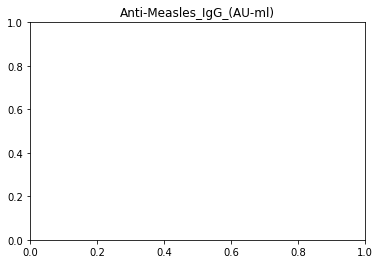

high_AB
{'BEX4', 'ELL3', 'DPY19L2P1', 'WDR11-AS1', 'BRS3', 'LOC105377621', 'LINC00550', 'SGOL2', 'LOC105369192', 'LOC105372266', 'PELI3', 'LIMD1-AS1', 'LOC105377981', 'LOC101927286', 'OPN1MW2', 'ZNF676', 'LOC105369735', 'LOC101929560', 'AMIGO1', 'LTF', 'NODAL', 'LOC101928068', 'LOC390860', 'SHANK1', 'LOC105378157', 'CYYR1-AS1', 'LOC105372965', 'MAGOHB', 'LOC105372725', 'VILL', 'KLHL34', 'LOC400446', 'UNC93B6', 'NAT14', 'EIF5A2', 'LINC01032', 'LOC102724418', 'TRPM8', 'PRELID1P1', 'ANKRD20A17P', 'TRNP', 'NUDT8', 'LOC105373415', 'HOOK1', 'LOC105377171', 'LINC00367', 'TTC29', 'LOC105374583', 'LOC105371729', 'AASDHPPT', 'RANBP6', 'LOC105379467', 'LOC101928347', 'TOM1L1', 'DDC', 'C18orf21', 'SOGA3', 'LOC105373987', 'CCNB2', 'KRT222', 'GABRA5', 'ZNF662', 'LOC101927964', 'DEFB123', 'RPL27AP6', 'RPS10P1', 'LOC105376797', 'SRD5A2', 'LOC102724365', 'LOC105372382', 'ADAMTS13', 'NR1H4', 'ELAVL2', 'LOC105379078', 'TMEM114', 'XGY2', 'LOC102723739', 'GPR158-AS1', 'LOC102724539', 'LOC105379345', 'YWHAZ

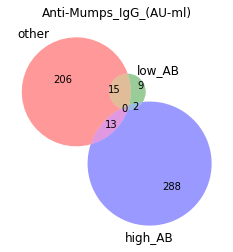

other
{'LOC105370304', 'NUTF2P7', 'LOC102723623', 'CHCHD3P3', 'PRKG1-AS1', 'LOC105369685', 'LOC105378815', 'LOC105377746', 'GLRA4', 'PRRT1', 'DMRT3', 'LOC105371313', 'FLJ41941', 'LOC101927196', 'FBXW11P1', 'LOC400612', 'MGP', 'LINC00458', 'CYP2T1P', 'LCN12', 'LOC401703', 'LOC105375904', 'LOC105371620', 'LOC105372618', 'FZD9', 'TNNT3', 'LOC105371531', 'LOC102723576', 'LOC105377268', 'RPLP2P4', 'LEFTY2', 'LOC105377883', 'LOC283887', 'TUBB2B', 'RPEL1', 'LOC105373318', 'LOC105377295', 'LOC105376683', 'LINC00305', 'LOC105373406', 'LOC105372587', 'DNMT3AP1', 'NAT8L', 'CYP2A7', 'LOC285043', 'CBX2', 'ZNF416', 'FAM167B', 'LOC105373378', 'LOC101929144', 'LOC101929707', 'ACR', 'LINC00251', 'HIST1H1B', 'OTX1', 'LOC105371343', 'LOC100418832', 'MIR573', 'RXRG', 'LINC01160', 'RPL21P32', 'ANKRD60', 'LOC105377696', 'T', 'LOC105377049', 'GNB3', 'LOC440514', 'HLA-F-AS1', 'ERICH3', 'LOC105378946', 'LOC100996721', 'LOC101929551', 'C15orf53', 'LOC101929527', 'NIPAL2', 'ZNF833P', 'AVPR2', 'KRT18P9', 'RPS3P3'

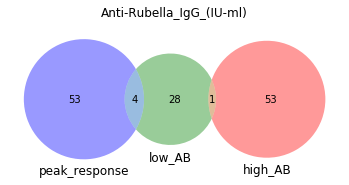

high_AB
{'TPPP', 'LOC101929756', 'LOC100293704', 'SERPINA6', 'LOC101927712', 'FBLL1', 'LOC101928504', 'SLC16A11', 'LOC389473', 'CICP11', 'MRPS18CP2', 'TRIM39-RPP21', 'LOC105377345', 'LOC105376039', 'LINC00593', 'RPL23AP44', 'HMGN3-AS1', 'LOC105371227', 'ATP5LP2', 'LOC646034', 'ABCC6P2', 'LINC00917', 'LOC100421782', 'RPS20P6', 'RPL39P38', 'LOC105379495', 'LOC105373320', 'TIPARP-AS1', 'LOC105376015', 'LOC101929408', 'GCOM2', 'LINC00160', 'MRGPRF', 'LOC105376389', 'LDHAP5', 'LOC105379358', 'RPS27P9', 'LOC105373983', 'NDN', 'ARL13A', 'LOC105372339', 'LOC105373254', 'TACR2', 'RPS15AP11', 'EEF1A1P1', 'ATP5G2P4', 'LOC105372821', 'RPL36AP21', 'KRT6A', 'LOC105377015', 'LINC00930', 'API5P1', 'SPDYC', 'LINC00514'}
low_AB
{'LOC105371195', 'AMN', 'LOC102724846', 'LARP1BP3', 'LOC105377769', 'LOC105378963', 'LOC100533641', 'LOC101929406', 'CHORDC2P', 'GLUD1P4', 'LOC645163', 'CALHM1', 'RPS10P12', 'KRT8P21', 'LOC105375050', 'LOC105376906', 'LOC105370421', 'OR2K2', 'LOC105375975', 'DNM1P35', 'LINC00514'

In [19]:
for virus in enrich_df['vaccine'].unique():
    
    virus_df = enrich_df[enrich_df['vaccine']==virus]
    
    genes = {}
    
    for contrast in virus_df['contrast'].unique():
        print(virus, contrast)
        genes[contrast] = virus_df[virus_df['contrast']==contrast]['ncbi_gene'].values
        virus_df[virus_df['contrast']==contrast].to_csv(
            '../data/go_enrichment/degs/{}-{}-{}vs{}.tsv'.format(virus.replace('/', '_'), 
                                                             contrast, 
                                                             day_A, 
                                                             day_B),
            sep='\t')
        with open('../data/go_enrichment/degs/{}-{}-{}vs{}_list.txt'.format(virus.replace('/', '_'), 
                                                             contrast, 
                                                             day_A, 
                                                             day_B), 
                  'w') as f:
            f.write('\n'.join(genes[contrast]))
        
    if len(virus_df['contrast'].unique()) == 2:
        venn2([set(value) for value in genes.values()], set_labels=[key for key in genes.keys()])
    elif len(virus_df['contrast'].unique()) == 3:
        venn3([set(value) for value in genes.values()], set_labels=[key for key in genes.keys()])
    plt.title(f'{virus}')
    plt.savefig('../figures/DEG_venn_{}_{}-{}.pdf'.format(virus.replace('/', ':'), day_A, day_B))
    plt.show()

    for key, value in genes.items():
        print(key)
        print(set(value))

In [20]:
#for vaccine in antibody_df['vaccine'].unique():
#    print(vaccine)
#    genes = {'no response - high ab': [],
#             'no response - low ab': [],
#             'responder': []}
#    virus_df = enrich_df[enrich_df['vaccine']==vaccine]
#    for group in virus_df[virus_df['contrast']=='quadrant']['group'].unique():
#        genes[group] = virus_df[(virus_df['contrast']=='quadrant') &
#                                  (virus_df['group']==group)]['ncbi_gene'].values
#    venn3([set(value) for value in genes.values()], set_labels=[key for key in sorted(genes.keys())])
#    plt.title(f'{vaccine}')
#    plt.savefig('../figures/DEG_venn_{}_{}-{}_quadrant.pdf'.format(vaccine.replace('/', ':'), day_A, day_B))
#    plt.show()
#    print(genes)

# Significant genes between timepoints (per group)

In [21]:
R_script_dir = '../code/generated_R_scripts'

readcount_df = GEA.collect_data('../original_data', file_pattern = '.*readcounts.txt')

to_drop = [col for col in readcount_df.columns if 'Undetermined' in col]
readcount_df = readcount_df.drop(columns=to_drop)

preproc = GEA.Preprocessor()
readcount_df = preproc.clean(readcount_df, data_origin='MMR')
readcount_df = preproc.combine_lane_counts(readcount_df)

readcount_df.to_csv('../data/readcount_combined.txt', sep='\t', index=False)
readcount_df[[col for col in readcount_df.columns if 'gene' in col]].T.to_csv('../data/readcount_combined_counts.txt', sep='\t')
readcount_df[[col for col in readcount_df.columns if 'gene' not in col]].to_csv('../data/readcount_combined_meta.txt', sep='\t', index=False)

genes = pd.read_csv('../original_data/genes.txt', sep='\t', header=None)
gene_dict = {x: genes.loc[i, 3] for i, x in enumerate(genes[0])}
#readcount_df = readcount_df.rename(columns=gene_dict)

readcount_df.head()

Searching files in ../original_data...
Searching files in ../original_data/read_counts...
File found: 170906_NB501809_0168_AH7NMHBGX3_readcounts.txt
File found: 171013_NB501809_0191_AHN7GCBGX3_readcounts.txt
File found: 171121_NB501809_0211_AHW3JCBGX3_readcounts.txt
File found: 170802_NB501809_0150_AH7NMJBGX3_readcounts.txt
File found: 171027_NB501809_0200_AHMLG2BGX3_readcounts.txt
File found: 170915_NB501809_0174_AHKCMHBGX3_readcounts.txt
File found: 170929_NB501809_0183_AHK5NLBGX3_readcounts.txt
Files found:
../original_data/read_counts/170906_NB501809_0168_AH7NMHBGX3_readcounts.txt
../original_data/read_counts/171013_NB501809_0191_AHN7GCBGX3_readcounts.txt
../original_data/read_counts/171121_NB501809_0211_AHW3JCBGX3_readcounts.txt
../original_data/read_counts/170802_NB501809_0150_AH7NMJBGX3_readcounts.txt
../original_data/read_counts/171027_NB501809_0200_AHMLG2BGX3_readcounts.txt
../original_data/read_counts/170915_NB501809_0174_AHKCMHBGX3_readcounts.txt
../original_data/read_counts

,gene27686,gene37698,gene37699,gene46570,gene46575,gene28963,gene26406,gene21713,gene16201,gene6756,...,gene10081,gene15800,gene6977,gene17256,gene1559,run,name,replicates,sample,day
name,,,,,,,,,,,,,,,,,,,,,
M11_EXP0_1_S28,1070064.0,615748.0,156563.0,70605.0,76505.0,12145.0,8333.0,11419.0,19828.0,5359.0,...,0.0,0.0,0.0,0.0,0.0,170802_NB501809_0150_AH7NMJBGX3,M11_EXP0_1_S28,1,M11,0
M11_EXP0_2_S4,1793590.0,695796.0,231752.0,67744.0,57953.0,13144.0,17416.0,19287.0,20380.0,15599.0,...,0.0,0.0,0.0,0.0,0.0,171013_NB501809_0191_AHN7GCBGX3,M11_EXP0_2_S4,2,M11,0
M11_EXP3_1_S29,1424441.0,672075.0,316520.0,56197.0,44469.0,26590.0,9330.0,14056.0,8945.0,10140.0,...,0.0,0.0,0.0,0.0,0.0,170802_NB501809_0150_AH7NMJBGX3,M11_EXP3_1_S29,1,M11,3
M11_EXP3_2_S5,1828251.0,1212191.0,335492.0,140848.0,131412.0,11728.0,14102.0,18902.0,18389.0,16700.0,...,0.0,0.0,0.0,0.0,0.0,171013_NB501809_0191_AHN7GCBGX3,M11_EXP3_2_S5,2,M11,3
M11_EXP7_1_S30,826915.0,756994.0,221669.0,154362.0,137770.0,10450.0,7863.0,9424.0,20195.0,3848.0,...,0.0,0.0,0.0,0.0,0.0,170802_NB501809_0150_AH7NMJBGX3,M11_EXP7_1_S30,1,M11,7


In [22]:
left_out_days = ['0', '3', '7']
for left_out_day in left_out_days:
    print('Left out day: {}'.format(left_out_day))
    test_days = [x for x in left_out_days if x!=left_out_day]
    
    for group_label, group_dct in groups.items():
        all_samples = [y for x in group_dct.values() for y in x]
        for subgroup_label, vaccinee_list in group_dct.items():

            print(group_label, subgroup_label)
            print(vaccinee_list)

            out_samples = [x for x in all_samples if x not in vaccinee_list]
            regroup_dct = {subgroup_label: [f'M{x}' for x in vaccinee_list], 
                           f'non-{subgroup_label}': [f'M{x}' for x in out_samples]}

            lp = GEA.LabelProcessor(readcount_df, data_origin='MMR')
            for vaccinee in all_samples:
                lp.add_samples('sample', f'M{vaccinee}')
            lp.regroup_meta_tags('sample', 'group', regroup_dct)
            lp.remove_samples('group', f'non-{subgroup_label}')
            lp.remove_samples('day', left_out_day)
            
            
            dirpath = '../data/deseq2/{}_{}_{}'.format(group_label,
                                                       subgroup_label,
                                                       'vs'.join(test_days))

            try:
                os.mkdir(dirpath)
            except FileExistsError:
                pass
            
            lp.generate_DESeq_data(f'{dirpath}/read_counts.txt',
                                   f'{dirpath}/col_data.txt')

            run = GEA.DESeq2run(f'{dirpath}/read_counts.txt',
                                f'{dirpath}/col_data.txt',
                                sample_column='day')

            path = run.calc_DEGs(design = 'day',
                                 to_test={'day': test_days},
                                 R_script_dir=dirpath)
            print()

Left out day: 0
Anti-Measles_IgG_(AU-ml) high_AB
[41, 39, 38, 33, 18, 12, 15, 9, 40, 8, 13, 35]
Starting R process - day: 3 vs 7

Anti-Measles_IgG_(AU-ml) low_AB
[26, 21, 25, 20, 22, 29, 3]
Starting R process - day: 3 vs 7

Anti-Measles_IgG_(AU-ml) peak_response
[28, 1, 16, 19]
Starting R process - day: 3 vs 7

Anti-Measles_IgG_(AU-ml) long_response
[23, 14, 4, 11, 36, 37, 2, 5, 30, 32, 6, 17, 27, 7, 31, 24, 34]
Starting R process - day: 3 vs 7

Anti-Mumps_IgG_(AU-ml) low_AB
[29, 1, 20, 23, 32, 11, 40]
Starting R process - day: 3 vs 7

Anti-Mumps_IgG_(AU-ml) high_AB
[41, 4, 3, 27, 25, 18, 22, 31, 6, 9, 21, 24]
Starting R process - day: 3 vs 7

Anti-Mumps_IgG_(AU-ml) other
[8, 37, 38, 35, 7, 39, 12, 17, 15, 26, 16, 30, 13, 33, 5, 19, 36, 2, 14, 28, 34]
Starting R process - day: 3 vs 7

Anti-Rubella_IgG_(IU-ml) low_AB
[22, 32, 15, 33, 24, 8, 28, 14, 35, 40, 2, 1, 11, 36, 38, 4, 6, 5, 20, 23, 30, 12, 37]
Starting R process - day: 3 vs 7

Anti-Rubella_IgG_(IU-ml) peak_response
[17, 19, 9, 

In [29]:
for dr, subdr, files in os.walk('/Users/nicolasdeneuter/Dropbox/PhD/Projects/GOA/MMR/RNAseq/data/deseq2'):
    results = [x for x in files if ('DESeq2_results_day' in x) and (x.split('_')[-1].replace('.txt', '') not in ['map', 'go', 'sig', 'ids'])]
    for path in results:
        path = '{}/{}'.format(dr, path)
        deg_result = GEA.DESeq2results(results_file=path)
        deg_result.get_sig_DEGs(write_to=path.replace('.txt', '_sig.txt'))

# Significant genes per group - DESeq2 (same timepoint)

In [30]:
R_script_dir = '../code/generated_R_scripts'

readcount_df = GEA.collect_data('../original_data', file_pattern = '.*readcounts.txt')

to_drop = [col for col in readcount_df.columns if 'Undetermined' in col]
readcount_df = readcount_df.drop(columns=to_drop)

preproc = GEA.Preprocessor()
readcount_df = preproc.clean(readcount_df, data_origin='MMR')
readcount_df = preproc.combine_lane_counts(readcount_df)

readcount_df.to_csv('../data/readcount_combined.txt', sep='\t', index=False)
readcount_df[[col for col in readcount_df.columns if 'gene' in col]].T.to_csv('../data/readcount_combined_counts.txt', sep='\t')
readcount_df[[col for col in readcount_df.columns if 'gene' not in col]].to_csv('../data/readcount_combined_meta.txt', sep='\t', index=False)

genes = pd.read_csv('../original_data/genes.txt', sep='\t', header=None)
gene_dict = {x: genes.loc[i, 3] for i, x in enumerate(genes[0])}
#readcount_df = readcount_df.rename(columns=gene_dict)

Searching files in ../original_data...
Searching files in ../original_data/read_counts...
File found: 170906_NB501809_0168_AH7NMHBGX3_readcounts.txt
File found: 171013_NB501809_0191_AHN7GCBGX3_readcounts.txt
File found: 171121_NB501809_0211_AHW3JCBGX3_readcounts.txt
File found: 170802_NB501809_0150_AH7NMJBGX3_readcounts.txt
File found: 171027_NB501809_0200_AHMLG2BGX3_readcounts.txt
File found: 170915_NB501809_0174_AHKCMHBGX3_readcounts.txt
File found: 170929_NB501809_0183_AHK5NLBGX3_readcounts.txt
Files found:
../original_data/read_counts/170906_NB501809_0168_AH7NMHBGX3_readcounts.txt
../original_data/read_counts/171013_NB501809_0191_AHN7GCBGX3_readcounts.txt
../original_data/read_counts/171121_NB501809_0211_AHW3JCBGX3_readcounts.txt
../original_data/read_counts/170802_NB501809_0150_AH7NMJBGX3_readcounts.txt
../original_data/read_counts/171027_NB501809_0200_AHMLG2BGX3_readcounts.txt
../original_data/read_counts/170915_NB501809_0174_AHKCMHBGX3_readcounts.txt
../original_data/read_counts

In [31]:
days = [0, 3, 7]
for day in days:
    for group_label, group_dct in groups.items():
        all_samples = [y for x in group_dct.values() for y in x]
        for subgroup_label, vaccinee_list in group_dct.items():
            print(day, group_label, subgroup_label)
            
            out_samples = [x for x in all_samples if x not in vaccinee_list]
            regroup_dct = {subgroup_label: [f'M{x}' for x in vaccinee_list], 
                           f'non-{subgroup_label}': [f'M{x}' for x in out_samples]}
            
            lp = GEA.LabelProcessor(readcount_df, data_origin='MMR')
            lp.add_samples('day', str(day))
            lp.regroup_meta_tags('sample', 'group', regroup_dct)
            
            dirpath = '../data/deseq2/{}_day{}_{}'.format(group_label,
                                                          day,
                                                          subgroup_label)
            
            try:
                os.mkdir(dirpath)
            except FileExistsError:
                pass
                    
            lp.generate_DESeq_data(f'{dirpath}/read_counts.txt',
                                   f'{dirpath}/col_data.txt')

            
            run = GEA.DESeq2run(f'{dirpath}/read_counts.txt',
                                f'{dirpath}/col_data.txt',
                                sample_column='group')
            
            path = run.calc_DEGs(design = 'group',
                                 to_test={'group': list(regroup_dct.keys())},
                                 R_script_dir=dirpath)
            print()       

0 Anti-Measles_IgG_(AU-ml) high_AB
Starting R process - group: high_AB vs non-high_AB

0 Anti-Measles_IgG_(AU-ml) low_AB
Starting R process - group: low_AB vs non-low_AB

0 Anti-Measles_IgG_(AU-ml) peak_response
Starting R process - group: peak_response vs non-peak_response

0 Anti-Measles_IgG_(AU-ml) long_response
Starting R process - group: long_response vs non-long_response

0 Anti-Mumps_IgG_(AU-ml) low_AB
Starting R process - group: low_AB vs non-low_AB

0 Anti-Mumps_IgG_(AU-ml) high_AB
Starting R process - group: high_AB vs non-high_AB

0 Anti-Mumps_IgG_(AU-ml) other
Starting R process - group: other vs non-other

0 Anti-Rubella_IgG_(IU-ml) low_AB
Starting R process - group: low_AB vs non-low_AB

0 Anti-Rubella_IgG_(IU-ml) peak_response
Starting R process - group: peak_response vs non-peak_response

0 Anti-Rubella_IgG_(IU-ml) high_AB
Starting R process - group: high_AB vs non-high_AB

3 Anti-Measles_IgG_(AU-ml) high_AB
Starting R process - group: high_AB vs non-high_AB

3 Anti-Mea

In [34]:
for dr, subdr, files in os.walk('/Users/nicolasdeneuter/Dropbox/PhD/Projects/GOA/MMR/RNAseq/data/deseq2'):
    results = [x for x in files if ('DESeq2_results_day' in x) and (x.split('_')[-1].replace('.txt', '') not in ['map', 'go', 'sig', 'ids'])]
    for path in results:
        path = '{}/{}'.format(dr, path)
        deg_result = GEA.DESeq2results(results_file=path)
        deg_result.get_sig_DEGs(write_to=path.replace('.txt', '_sig.txt'))

# Significant genes between timepoints (no groups)
- day 0 vs 3 vs 7 comparison without including anything else

In [35]:
R_script_dir = '../code/generated_R_scripts'

readcount_df = GEA.collect_data('../original_data', file_pattern = '.*readcounts.txt')

to_drop = [col for col in readcount_df.columns if 'Undetermined' in col]
readcount_df = readcount_df.drop(columns=to_drop)

preproc = GEA.Preprocessor()
readcount_df = preproc.clean(readcount_df, data_origin='MMR')
readcount_df = preproc.combine_lane_counts(readcount_df)

readcount_df.to_csv('../data/readcount_combined.txt', sep='\t', index=False)

genes = pd.read_csv('../original_data/genes.txt', sep='\t', header=None)
gene_dict = {x: genes.loc[i, 3] for i, x in enumerate(genes[0])}
#readcount_df = readcount_df.rename(columns=gene_dict)

readcount_df.head()

lp = GEA.LabelProcessor(readcount_df, data_origin='MMR')
lp.add_samples('day', '0')
lp.add_samples('day', '3')
lp.add_samples('day', '7')

try:
    os.mkdir('../data/timepoint_comparison')
except FileExistsError:
    pass
    
print(lp.generate_DESeq_data('../data/timepoint_comparison/read_counts.txt',
                             '../data/timepoint_comparison/col_data.txt'))

Searching files in ../original_data...
Searching files in ../original_data/read_counts...
File found: 170906_NB501809_0168_AH7NMHBGX3_readcounts.txt
File found: 171013_NB501809_0191_AHN7GCBGX3_readcounts.txt
File found: 171121_NB501809_0211_AHW3JCBGX3_readcounts.txt
File found: 170802_NB501809_0150_AH7NMJBGX3_readcounts.txt
File found: 171027_NB501809_0200_AHMLG2BGX3_readcounts.txt
File found: 170915_NB501809_0174_AHKCMHBGX3_readcounts.txt
File found: 170929_NB501809_0183_AHK5NLBGX3_readcounts.txt
Files found:
../original_data/read_counts/170906_NB501809_0168_AH7NMHBGX3_readcounts.txt
../original_data/read_counts/171013_NB501809_0191_AHN7GCBGX3_readcounts.txt
../original_data/read_counts/171121_NB501809_0211_AHW3JCBGX3_readcounts.txt
../original_data/read_counts/170802_NB501809_0150_AH7NMJBGX3_readcounts.txt
../original_data/read_counts/171027_NB501809_0200_AHMLG2BGX3_readcounts.txt
../original_data/read_counts/170915_NB501809_0174_AHKCMHBGX3_readcounts.txt
../original_data/read_counts

In [36]:
# make R script and run it to normalize gene counts
run = GEA.DESeq2run('../data/timepoint_comparison/read_counts.txt',
                    '../data/timepoint_comparison/col_data.txt',
                    sample_column='sample')

result_paths = {}
paths = ['../data/timepoint_comparison/DESeq2_results_day-0vs3.txt', 
         '../data/timepoint_comparison/DESeq2_results_day-0vs7.txt',
         '../data/timepoint_comparison/DESeq2_results_day-3vs7.txt']

folds = [0, 0.5, 1]
for i, combination in enumerate(list(itertools.combinations('037', 2))):
    print('{}_{}'.format(combination[0], combination[1]))
    if not os.path.isfile(paths[i]):
        path = run.calc_DEGs(design = 'day',
                             to_test={'day': [combination[0], combination[1]]},
                             R_script_dir='../data/timepoint_comparison')
        path = path[0] # calc_DEGs returns a list containing a path for each test it did
    else:
        path = paths[i]
        
    deg_result = GEA.DESeq2results(results_file=path)
    for i in folds:
        print(i)
        deg_result.get_sig_DEGs(write_to=path.replace('.txt', f'_fold{i}_sig.txt'), fold_threshold=i)
        result_paths['{}_{}_fold{}'.format(combination[0], combination[1], i)] = path.replace('.txt', f'_fold{i}_sig.txt')    
print(result_paths)

0_3
0
0.5
1
0_7
0
0.5
1
3_7
0
0.5
1
{'0_3_fold0': '../data/timepoint_comparison/DESeq2_results_day-0vs3_fold0_sig.txt', '0_3_fold0.5': '../data/timepoint_comparison/DESeq2_results_day-0vs3_fold0.5_sig.txt', '0_3_fold1': '../data/timepoint_comparison/DESeq2_results_day-0vs3_fold1_sig.txt', '0_7_fold0': '../data/timepoint_comparison/DESeq2_results_day-0vs7_fold0_sig.txt', '0_7_fold0.5': '../data/timepoint_comparison/DESeq2_results_day-0vs7_fold0.5_sig.txt', '0_7_fold1': '../data/timepoint_comparison/DESeq2_results_day-0vs7_fold1_sig.txt', '3_7_fold0': '../data/timepoint_comparison/DESeq2_results_day-3vs7_fold0_sig.txt', '3_7_fold0.5': '../data/timepoint_comparison/DESeq2_results_day-3vs7_fold0.5_sig.txt', '3_7_fold1': '../data/timepoint_comparison/DESeq2_results_day-3vs7_fold1_sig.txt'}


0
../data/timepoint_comparison/DESeq2_results_day-0vs3_fold0_sig.txt
(4400, 9)
../data/timepoint_comparison/DESeq2_results_day-0vs7_fold0_sig.txt
(6616, 9)
../data/timepoint_comparison/DESeq2_results_day-3vs7_fold0_sig.txt
(2, 9)


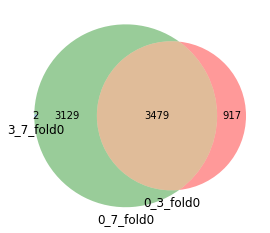

0.5
../data/timepoint_comparison/DESeq2_results_day-0vs3_fold0.5_sig.txt
(447, 9)
../data/timepoint_comparison/DESeq2_results_day-0vs7_fold0.5_sig.txt
(1675, 9)
../data/timepoint_comparison/DESeq2_results_day-3vs7_fold0.5_sig.txt
(2, 9)


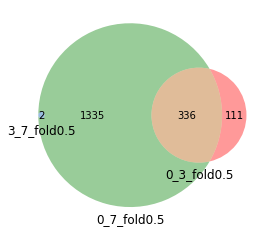

1
../data/timepoint_comparison/DESeq2_results_day-0vs3_fold1_sig.txt
(1, 9)
../data/timepoint_comparison/DESeq2_results_day-0vs7_fold1_sig.txt
(84, 9)
../data/timepoint_comparison/DESeq2_results_day-3vs7_fold1_sig.txt
(1, 9)


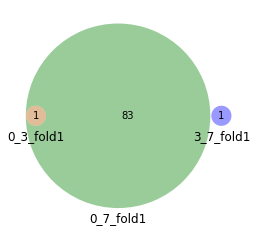

In [37]:
for i in folds:
    print(i)
    deg_dfs = []
    for contrast, path in result_paths.items():
        if 'fold{}_'.format(i) in path:
            print(path)
            df = pd.read_csv(path, sep='\t')
            df['genes'].to_csv('../data/go_enrichment/degs/{}'.format(path.split('/')[-1]).replace('.txt', '_list.txt'), 
                              index=False)
            df['contrast'] = contrast
            
            print(df.shape)
            deg_dfs.append(df)
    deg_df = pd.concat(deg_dfs)
    
    if len(deg_df['contrast'].unique()) == 2:
        venn2([set(deg_df[deg_df['contrast']==fold]['genes'].values) for fold in deg_df['contrast'].unique()],
             set_labels=[contrast for contrast in deg_df['contrast'].unique()])
    if len(deg_df['contrast'].unique()) == 3:
        venn3([set(deg_df[deg_df['contrast']==fold]['genes'].values) for fold in deg_df['contrast'].unique()],
             set_labels=[contrast for contrast in deg_df['contrast'].unique()])
    plt.savefig('../figures/DEG_venn_timepoint_fold{}.pdf'.format(i))
    plt.show()

# Unsupervised approach

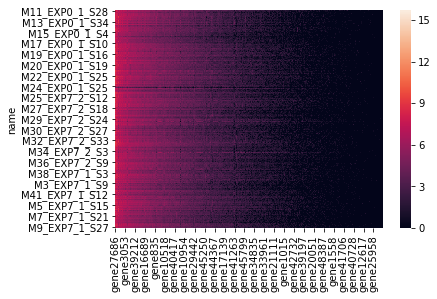

In [38]:
# unnormalized read counts
gene_cols = [col for col in readcount_df.columns if 'gene' in col]
sns.heatmap(readcount_df[gene_cols].applymap(lambda x: math.log(x+1)))
plt.show()

In [39]:
lp = GEA.LabelProcessor(readcount_df, data_origin='MMR')
lp.add_samples('day', '0')
lp.add_samples('day', '3')
lp.add_samples('day', '7')

lp.generate_DESeq_data('../data/timepoint_comparison/read_counts.txt',
                       '../data/timepoint_comparison/col_data.txt')

('../data/timepoint_comparison/read_counts.txt',
 '../data/timepoint_comparison/col_data.txt')

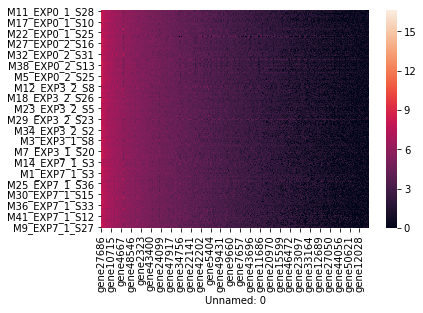

In [40]:
normalized_count_df = pd.read_csv('../data/timepoint_comparison/DESeq2_normalized_readcounts.txt', sep=',')
normalized_count_df = normalized_count_df.set_index('Unnamed: 0').T
sns.heatmap(normalized_count_df.applymap(lambda x: math.log(x+1)))
plt.show()

In [41]:
metadata = pd.DataFrame(pd.DataFrame(normalized_count_df.index.str.split('_').tolist(), columns=['person', 'day', 'replicate', 'other']))
metadata['norm_index'] = normalized_count_df.index
metadata = pd.merge(left=metadata, right=antibody_df, left_on='person', right_on='vaccinee', how='left')
metadata

,person,day,replicate,other,norm_index,vaccine,vaccinee,0,21,150,365,group
0,M11,EXP0,1,S28,M11_EXP0_1_S28,Anti-Measles_IgG_(AU-ml),M11,17.9,30.1,300.0,214.0,long_response
1,M11,EXP0,1,S28,M11_EXP0_1_S28,Anti-Mumps_IgG_(AU-ml),M11,11.8,50.5,26.5,12.4,low_AB
2,M11,EXP0,1,S28,M11_EXP0_1_S28,Anti-Rubella_IgG_(IU-ml),M11,12.5,69.2,29.2,28.3,low_AB
3,M11,EXP0,2,S4,M11_EXP0_2_S4,Anti-Measles_IgG_(AU-ml),M11,17.9,30.1,300.0,214.0,long_response
4,M11,EXP0,2,S4,M11_EXP0_2_S4,Anti-Mumps_IgG_(AU-ml),M11,11.8,50.5,26.5,12.4,low_AB
5,M11,EXP0,2,S4,M11_EXP0_2_S4,Anti-Rubella_IgG_(IU-ml),M11,12.5,69.2,29.2,28.3,low_AB
6,M12,EXP0,1,S31,M12_EXP0_1_S31,Anti-Measles_IgG_(AU-ml),M12,300.0,300.0,300.0,300.0,high_AB
7,M12,EXP0,1,S31,M12_EXP0_1_S31,Anti-Mumps_IgG_(AU-ml),M12,51.9,288.0,171.0,183.0,other
8,M12,EXP0,1,S31,M12_EXP0_1_S31,Anti-Rubella_IgG_(IU-ml),M12,17.4,67.2,43.5,39.3,low_AB
9,M12,EXP0,2,S7,M12_EXP0_2_S7,Anti-Measles_IgG_(AU-ml),M12,300.0,300.0,300.0,300.0,high_AB


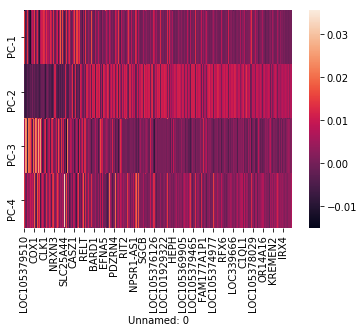

In [42]:
from sklearn import decomposition
from sklearn.preprocessing import minmax_scale

pca = decomposition.PCA(n_components=4, random_state=0)
X = minmax_scale(normalized_count_df, axis=0)
X = pd.DataFrame(pca.fit_transform(X))
X['norm_index'] = normalized_count_df.index

component_df = pd.DataFrame(pca.components_,columns=normalized_count_df.columns,index = ['PC-1', 'PC-2', 'PC-3', 'PC-4'])
component_df = component_df[[col for col in component_df.columns if sum(component_df[col]) > 0.01 ]]
sns.heatmap(component_df.rename(columns=gene_dict))
plt.savefig('../figures/PCs_explained_heatmap.pdf')
plt.show()

Anti-Measles_IgG_(AU-ml)


,0,1,2,3,4,hue
0,-10.332332,8.907037,-3.680459,1.798940,M11_EXP0_1_S28,long_response
1,-8.429198,-5.589539,-4.858702,1.899496,M11_EXP0_2_S4,long_response
2,2.817508,-5.815730,-5.576581,7.446724,M12_EXP0_1_S31,high_AB
3,-1.383305,-9.542186,-5.037779,5.037109,M12_EXP0_2_S7,high_AB
4,1.522195,-4.359255,1.377396,8.309561,M13_EXP0_1_S34,high_AB


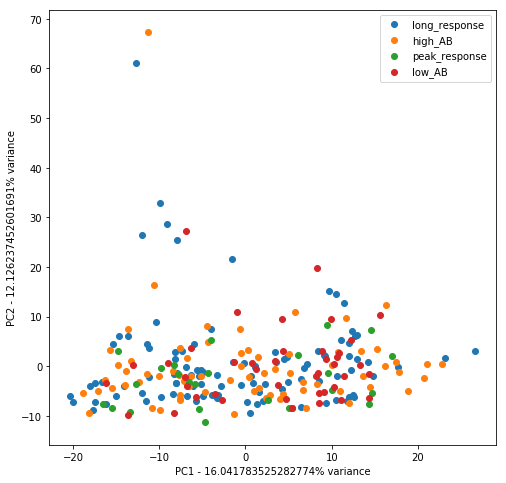

<Figure size 432x288 with 0 Axes>

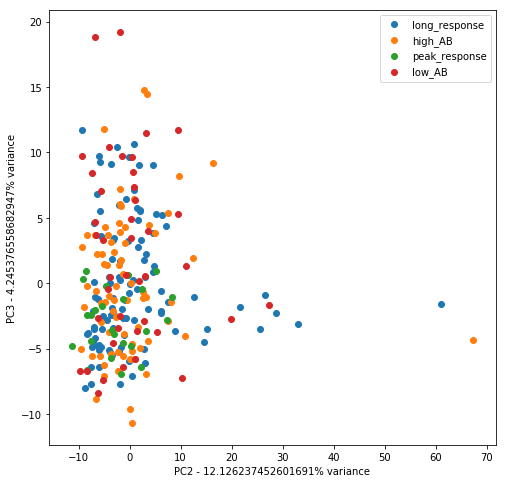

<Figure size 432x288 with 0 Axes>

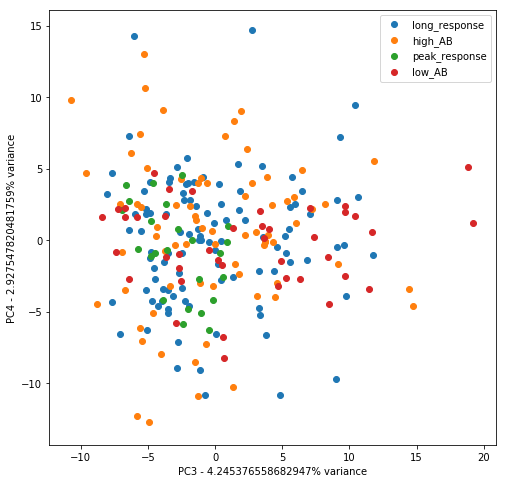

Anti-Mumps_IgG_(AU-ml)


,0,1,2,3,4,hue
0,-10.332332,8.907037,-3.680459,1.798940,M11_EXP0_1_S28,low_AB
1,-8.429198,-5.589539,-4.858702,1.899496,M11_EXP0_2_S4,low_AB
2,2.817508,-5.815730,-5.576581,7.446724,M12_EXP0_1_S31,other
3,-1.383305,-9.542186,-5.037779,5.037109,M12_EXP0_2_S7,other
4,1.522195,-4.359255,1.377396,8.309561,M13_EXP0_1_S34,other


<Figure size 432x288 with 0 Axes>

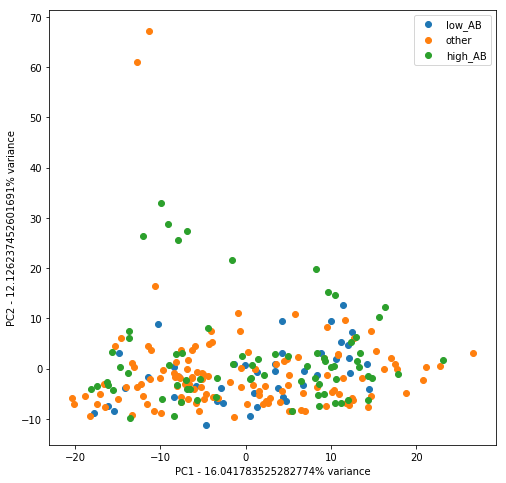

<Figure size 432x288 with 0 Axes>

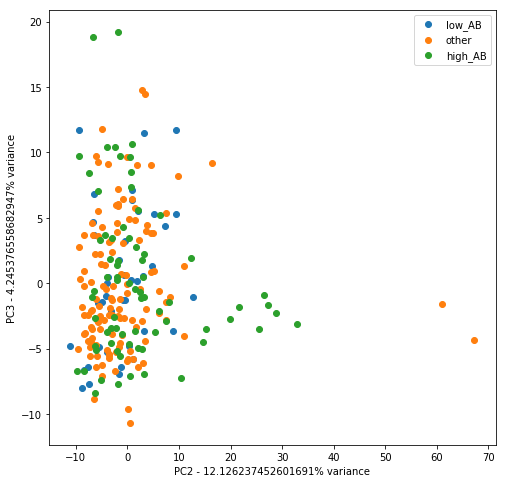

<Figure size 432x288 with 0 Axes>

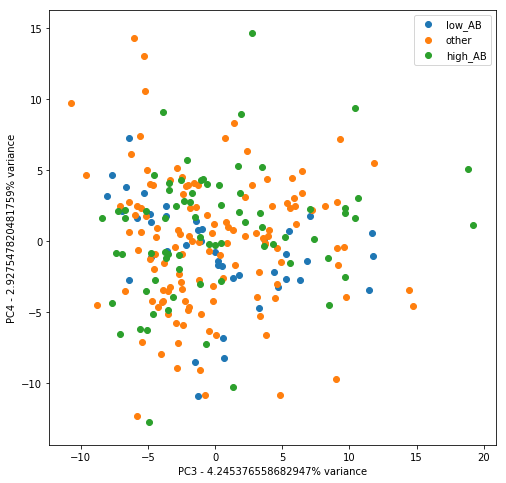

Anti-Rubella_IgG_(IU-ml)


,0,1,2,3,4,hue
0,-10.332332,8.907037,-3.680459,1.798940,M11_EXP0_1_S28,low_AB
1,-8.429198,-5.589539,-4.858702,1.899496,M11_EXP0_2_S4,low_AB
2,2.817508,-5.815730,-5.576581,7.446724,M12_EXP0_1_S31,low_AB
3,-1.383305,-9.542186,-5.037779,5.037109,M12_EXP0_2_S7,low_AB
4,1.522195,-4.359255,1.377396,8.309561,M13_EXP0_1_S34,high_AB


<Figure size 432x288 with 0 Axes>

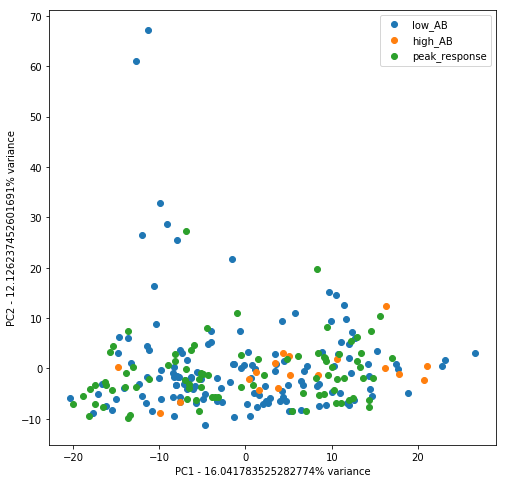

<Figure size 432x288 with 0 Axes>

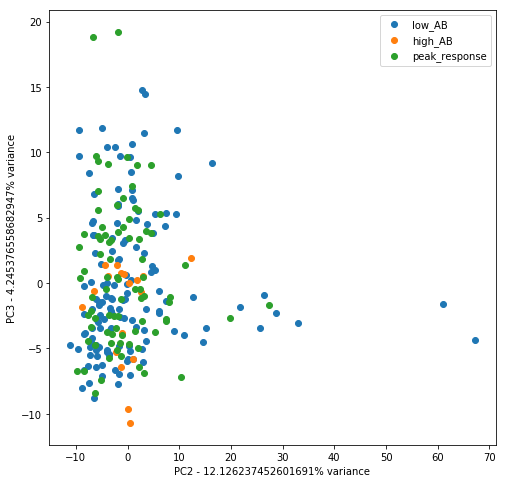

<Figure size 432x288 with 0 Axes>

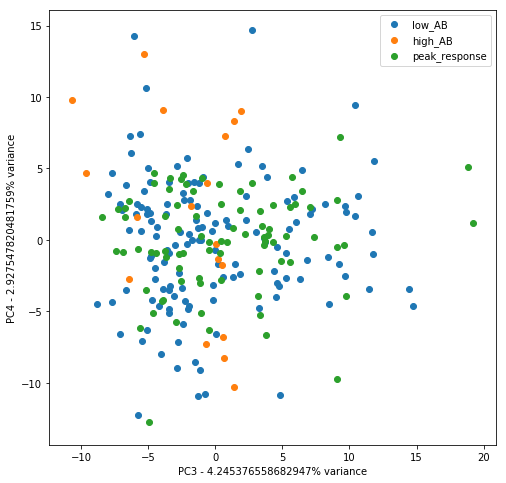

<Figure size 432x288 with 0 Axes>

In [43]:
for vaccine in antibody_df['vaccine'].unique():
    
    color_by = 'group'
    
    print(vaccine)
    
    X = pd.DataFrame(pca.fit_transform(minmax_scale(normalized_count_df)))
    X['norm_index'] = normalized_count_df.index
    Y = metadata[metadata['vaccine']==vaccine][color_by].reset_index(drop=True)
    X = pd.concat([X, Y], ignore_index=True, axis=1)
    
    X.columns = [str(x) for x in X.columns[:-1]]+['hue']
    
    display(X.head())
    
    for i in range(3):

        plt.subplots(figsize=[8, 8])
        for factor in X['hue'].unique():
            factor_mask = X['hue'] == factor
            plt.scatter(X.loc[factor_mask, str(i)], X.loc[factor_mask, str(i+1)], label=factor)
        plt.xlabel('PC{} - {}% variance'.format(i+1, pca.explained_variance_ratio_[i]*100))
        plt.ylabel('PC{} - {}% variance'.format(i+2, pca.explained_variance_ratio_[i+1]*100))
        plt.legend()
        
        plt.savefig('../figures/PCA_quadrant_{}_PC{}-PC{}.pdf'.format(vaccine.replace('/', ':'), i+1, i+2))
        plt.show()        

        plt.clf()

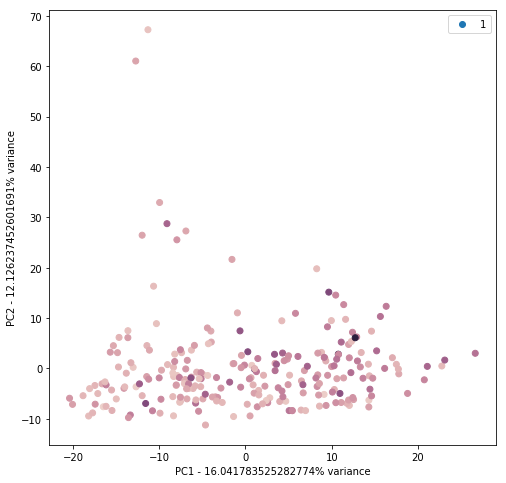

<Figure size 432x288 with 0 Axes>

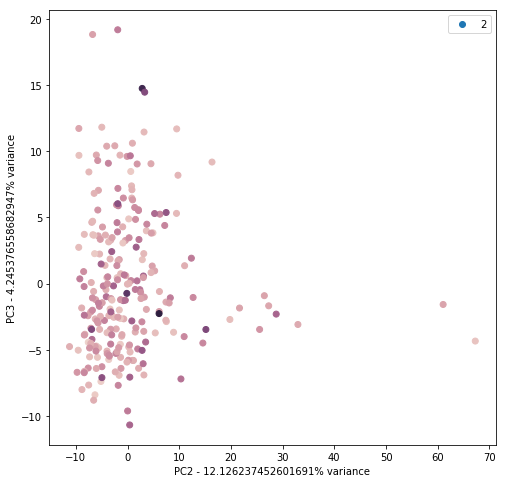

<Figure size 432x288 with 0 Axes>

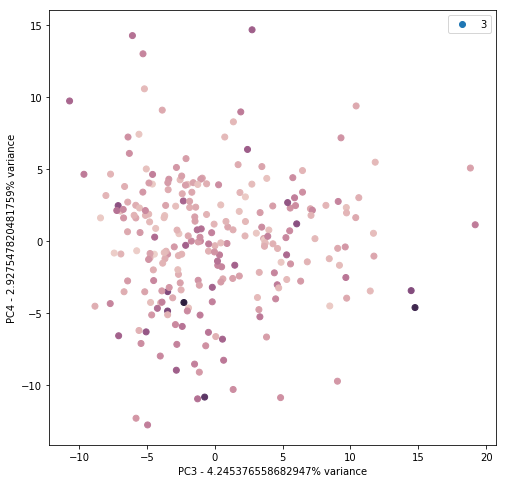

<Figure size 432x288 with 0 Axes>

In [44]:
for i in range(3):

    cmap = sns.cubehelix_palette(as_cmap=True)
    fig, ax = plt.subplots(figsize=(8,8))
    ax.scatter(data=X, x=str(i), y=str(i+1), cmap=cmap, c=normalized_count_df['gene37698'])
    plt.xlabel('PC{} - {}% variance'.format(i+1, pca.explained_variance_ratio_[i]*100))
    plt.ylabel('PC{} - {}% variance'.format(i+2, pca.explained_variance_ratio_[i+1]*100))
    plt.legend()

    plt.savefig(f'../figures/PCA_HBB_PC{i+1}-PC{i+2}.pdf')
    plt.show()        

    plt.clf()

# Cell types

In [45]:
cibersort_output = '../data/CIBERSORT.Output_Job1.txt'
cibersort_df = pd.read_csv(cibersort_output, sep='\t', index_col='Input Sample')
cell_columns = [col for col in cibersort_df if col not in ['P-value', 'Pearson Correlation', 'RMSE']]
cibersort_df = cibersort_df[cell_columns]
cibersort_df.set_index=('Input Sample')

In [46]:
# clustering method and distance metric to use
method = 'ward'
distance = 'euclidean'

# cluster rows together
D_rows = squareform(pdist(cibersort_df, distance))
Z_rows = linkage(D_rows, method)
optimal_Z_rows = linkage(D_rows, method, optimal_ordering=True)

# cluster columns together
D_cols = squareform(pdist(cibersort_df.T, distance))
Z_cols = linkage(D_cols, method)
optimal_Z_cols = linkage(D_cols, method, optimal_ordering=True)

# add categorical label to plot to reflect row labels
labels = pd.Series(cibersort_df.index).apply(lambda x: '_'.join(x.split('_')[1:2]))
#colors = sns.color_palette("cubehelix", len(labels.unique()))
colors = sns.color_palette("coolwarm", 3)
color_dict = dict(zip(labels.unique(), colors))
row_colors = pd.Series(labels).map(color_dict)
row_colors.index = cibersort_df.index

/Users/nicolasdeneuter/miniconda3/envs/mmr_rna/lib/python3.6/site-packages/ipykernel_launcher.py:7: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  import sys
/Users/nicolasdeneuter/miniconda3/envs/mmr_rna/lib/python3.6/site-packages/ipykernel_launcher.py:8: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  
/Users/nicolasdeneuter/miniconda3/envs/mmr_rna/lib/python3.6/site-packages/ipykernel_launcher.py:12: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  if sys.path[0] == '':
/Users/nicolasdeneuter/miniconda3/envs/mmr_rna/lib/python3.6/site-packages/ipykernel_launcher.py:13: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  

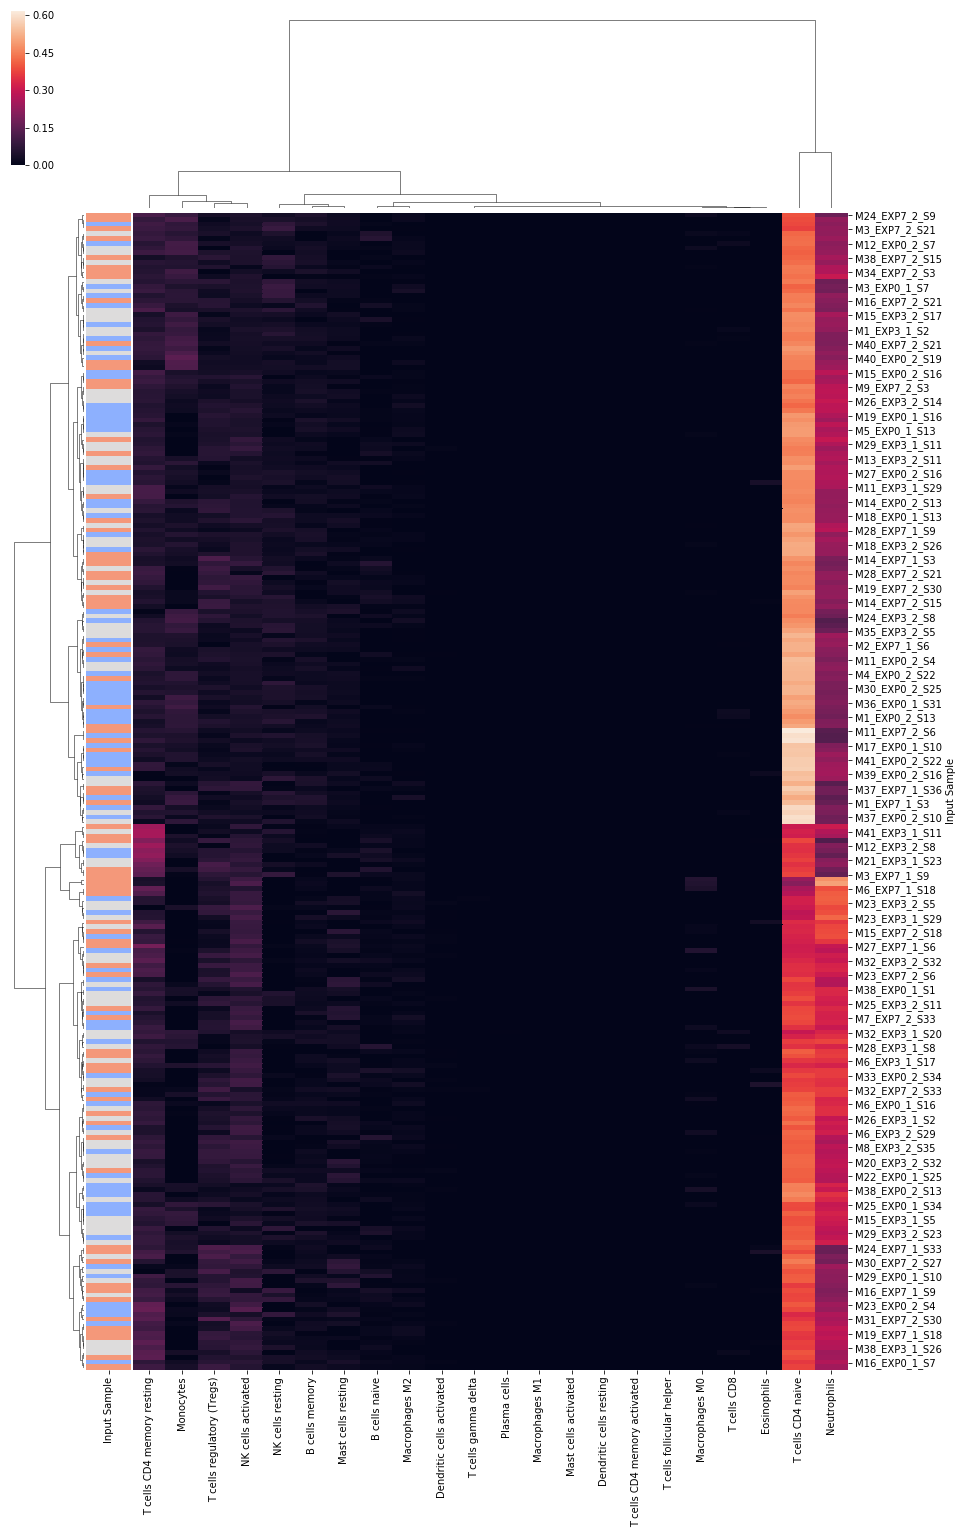

In [47]:
g = sns.clustermap(cibersort_df[cell_columns],
                   figsize=(15, 25),
                   row_linkage=Z_rows,
                   col_linkage=Z_cols,
                   row_colors=row_colors)
plt.savefig('../figures/heatmap_cibersort.pdf')
plt.show()